## **Apple leaves Classification using modified DenseNet169**

### importing dataset

In [ ]:
from google.colab import drive

# Mount Google Drive to '/content/drive'
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import cv2
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
def load_data(base_path, num_images_per_class_train=1000, num_images_per_class_test=600):
    subfolders = ["train", "test"]

    for subfolder in subfolders:
        subfolder_path = os.path.join(base_path, subfolder)

        for class_folder in os.listdir(subfolder_path):
            class_path = os.path.join(subfolder_path, class_folder)

            # Load a specific number of images for training and testing
            if subfolder == "train":
                class_images = os.listdir(class_path)[:num_images_per_class_train]
            elif subfolder == "test":
                class_images = os.listdir(class_path)[:num_images_per_class_test]

            for filename in class_images:
                img = Image.open(os.path.join(class_path, filename))
                img = img.resize((150, 150))  # Resize image
                img.save(os.path.join(class_path, filename))  # Overwrite the image with resized one

    # Now we can use flow_from_directory directly
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        zoom_range=0.2,
        shear_range=0.2,
        fill_mode='nearest',
        validation_split=0.2
    )

    train_generator = train_datagen.flow_from_directory(
        os.path.join(base_path, "train"),
        target_size=(150, 150),
        batch_size=8,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = train_datagen.flow_from_directory(
        os.path.join(base_path, "train"),
        target_size=(150, 150),
        batch_size=16,
        class_mode='categorical',
        subset='validation'
    )

    return train_generator, validation_generator

In [ ]:
# Specify the base path to your dataset
base_path = "/content/drive/My Drive/datasets/apple_leaves_normal/datasets"

# Load data using the modified load_data function
train_generator, validation_generator = load_data(base_path)

Found 6218 images belonging to 4 classes.
Found 1553 images belonging to 4 classes.


### model training

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout,BatchNormalization
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

In [ ]:
base_model = DenseNet169(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

base_model.trainable = False

model = Sequential()

model.add(base_model)

model.add(GlobalAveragePooling2D())
model.add(Flatten())

model.add(Dense(1024, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation="relu"))
model.add(BatchNormalization())

model.add(Dense(4, activation="softmax", name="classification"))

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

51877672/51877672 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 global_average_pooling2d (  (None, 1664)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 1664)              0         
                                                                 
 dense (Dense)               (None, 1024)              1704960   
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                         

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch,logs={}):
    if(logs.get('accuracy')>0.92):
      print("\nAccuracy has Achieved! Process Terminated!")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=20,
                    callbacks=callbacks,
                    batch_size=64)

Epoch 1/20
778/778 [==============================] - 148s 163ms/step - loss: 0.5841 - accuracy: 0.7863 - val_loss: 0.1359 - val_accuracy: 0.9530
Epoch 2/20
778/778 [==============================] - 105s 135ms/step - loss: 0.3568 - accuracy: 0.8713 - val_loss: 0.1309 - val_accuracy: 0.9594
Epoch 3/20
778/778 [==============================] - 107s 138ms/step - loss: 0.2961 - accuracy: 0.8922 - val_loss: 0.1012 - val_accuracy: 0.9710
Epoch 4/20
778/778 [==============================] - 103s 132ms/step - loss: 0.2765 - accuracy: 0.9014 - val_loss: 0.1224 - val_accuracy: 0.9659
Epoch 5/20
778/778 [==============================] - 105s 135ms/step - loss: 0.2425 - accuracy: 0.9138 - val_loss: 0.1277 - val_accuracy: 0.9575
Epoch 6/20
778/778 [==============================] - 106s 136ms/step - loss: 0.2403 - accuracy: 0.9119 - val_loss: 0.1022 - val_accuracy: 0.9742
Epoch 7/20
778/778 [==============================] - 104s 134ms/step - loss: 0.2263 - accuracy: 0.9165 - val_loss: 0.0931 -

In [ ]:
import matplotlib.pyplot as plt

def graph_plot(history, train, validation, title):
    plt.plot(history.history[train])
    plt.plot(history.history[validation])
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend(['Training', 'Validation'])
    plt.show()

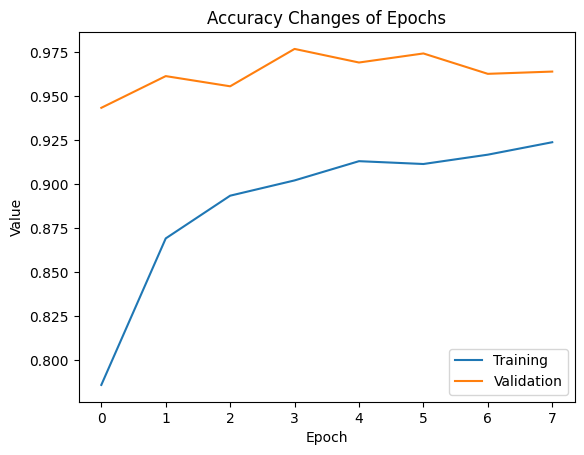

In [ ]:
graph_plot(history, 'accuracy', 'val_accuracy', 'Accuracy Changes of Epochs')

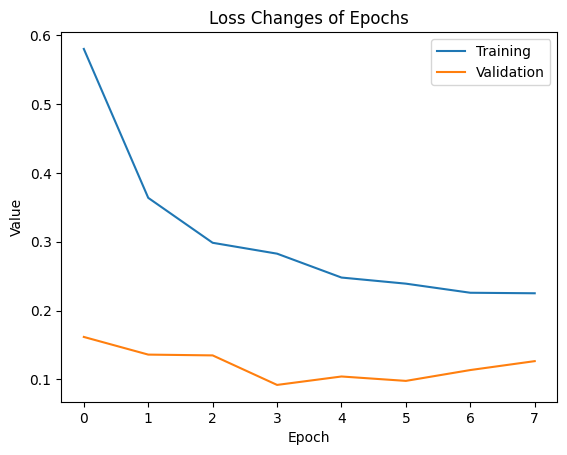

In [ ]:
graph_plot(history,'loss', 'val_loss', 'Loss Changes of Epochs')

98/98 [==============================] - 17s 175ms/step


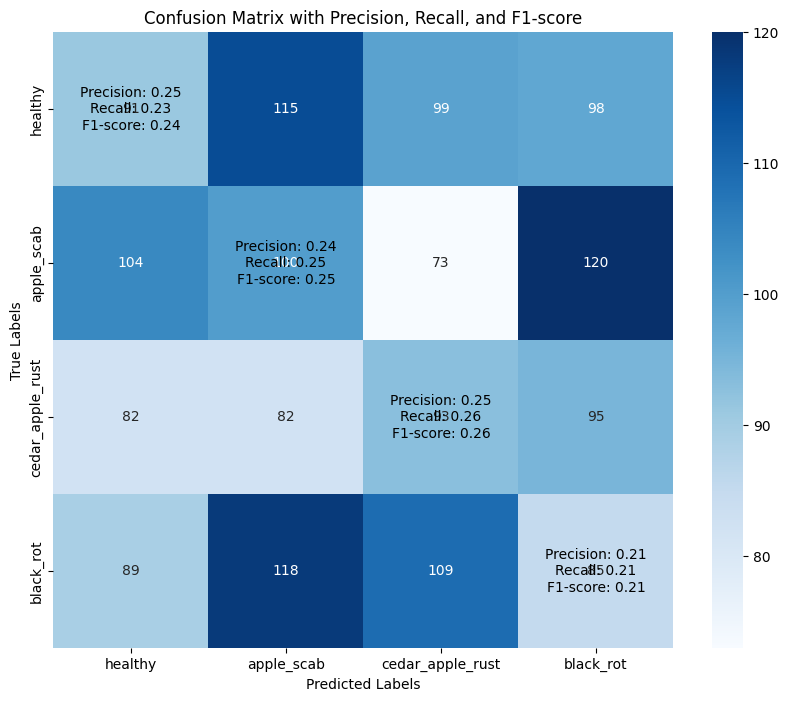

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

validation_steps = len(validation_generator)
y_pred = model.predict(validation_generator, steps=validation_steps)
y_true = validation_generator.classes

conf_matrix = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

class_names = ['healthy', 'apple_scab', 'cedar_apple_rust', 'black_rot']

# Calculate precision, recall, and F1-score for each class
report = classification_report(y_true, np.argmax(y_pred, axis=1), target_names=class_names, output_dict=True)

# Create a DataFrame to hold classification report metrics
metrics_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(10, 8))

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Add precision, recall, and F1-score as annotations
for i in range(len(class_names)):
    plt.text(i + 0.5, i + 0.5, f"Precision: {metrics_df['precision'][i]:.2f}\nRecall: {metrics_df['recall'][i]:.2f}\nF1-score: {metrics_df['f1-score'][i]:.2f}",
             horizontalalignment='center', verticalalignment='center', fontsize=10, color='black')

plt.title('Confusion Matrix with Precision, Recall, and F1-score')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

98/98 [==============================] - 24s 239ms/step


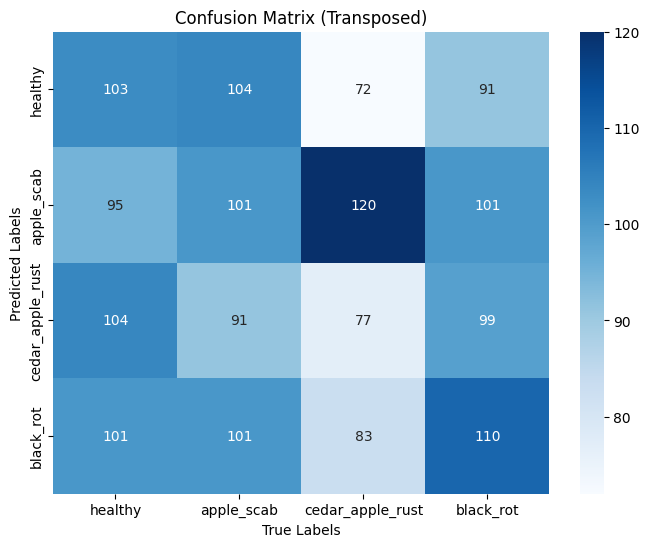

In [ ]:
validation_steps = len(validation_generator)
y_pred = model.predict(validation_generator, steps=validation_steps)
y_true = validation_generator.classes

conf_matrix = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

# Transpose the confusion matrix
conf_matrix_transposed = conf_matrix.T

class_names = ['healthy', 'apple_scab', 'cedar_apple_rust', 'black_rot']

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_transposed, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Transposed)')
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.show()

In [ ]:
model.save('dens.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### model application


In [ ]:
model = tf.keras.models.load_model('dens.h5')

In [ ]:
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    return img_array

In [ ]:
class_labels = {0: 'healthy', 1: 'apple_scab', 2: 'cedar_apple_rust', 3: 'black_rot'}

def predict_label(img_path):
    img_array = preprocess_image(img_path)
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    predicted_label = class_labels[predicted_class_index]
    return predicted_label

In [ ]:
img_path = "cedarapple.png"
predicted_label = predict_label(img_path)
print("Predicted label:", predicted_label)

1/1 [==============================] - 7s 7s/step
Predicted label: cedar_apple_rust
